# Install detectron2

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
#!git clone 'https://github.com/facebookresearch/detectron2'
#dist = distutils.core.run_setup("./detectron2/setup.py")
#!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
#sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 2.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-tb7mhf6t
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-tb7mhf6t
  Resolved https://github.com/facebookresearch/detectron2.git to commit 181aae36820af025eed1e33e58390f7ed9261e1a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

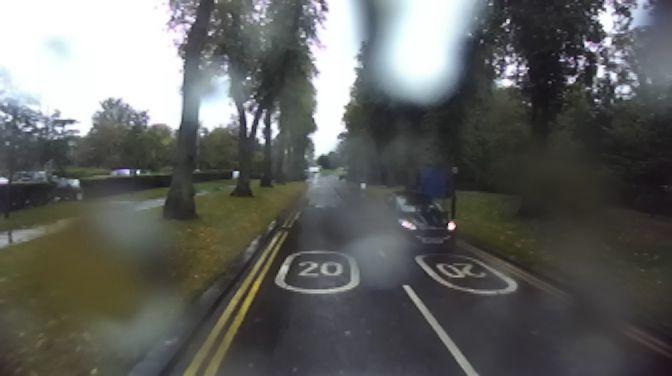

In [ ]:
im = cv2.imread("/content/000064.png")
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[04/23 20:17:02 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:00, 196MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)
bboxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()

tensor([2, 2, 2, 2], device='cuda:0')
Boxes(tensor([[  5.0806, 170.4398,  83.8348, 207.2001],
        [110.0632, 167.4866, 142.9072, 176.5687],
        [384.9749, 187.5824, 456.2925, 248.1112],
        [307.0425, 163.0291, 321.4285, 174.3553]], device='cuda:0'))


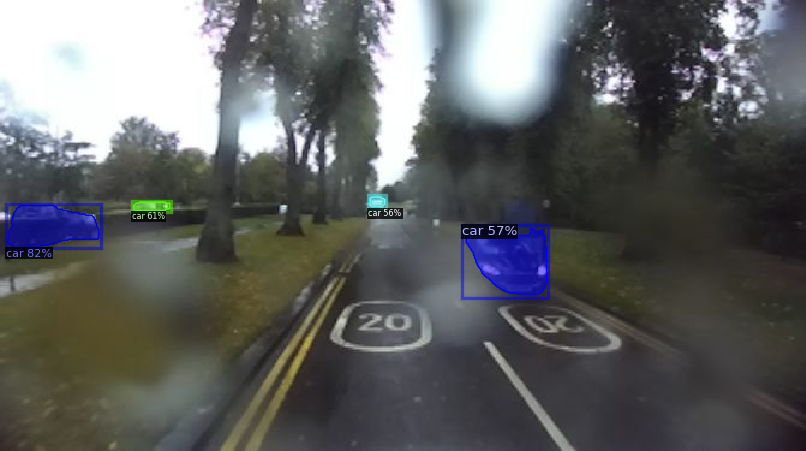

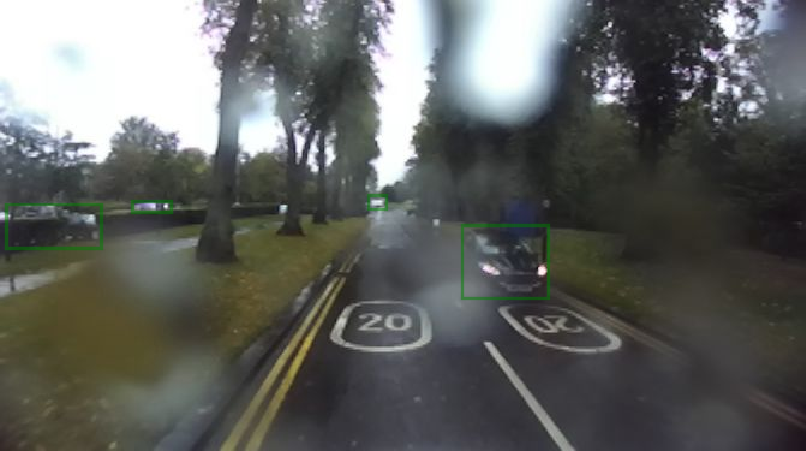

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

v = Visualizer(im[:, :, ::-1],
               MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
               scale=1.2
)
# Boxes
for box in outputs["instances"].pred_boxes.to('cpu'):
    v.draw_box(box)
v = v.get_output()
img =  v.get_image()[:, :, ::-1]
cv2_imshow(img)

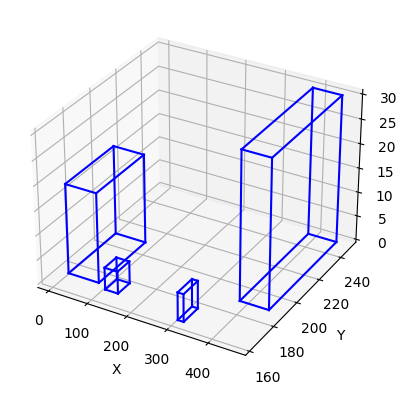

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_boxes(bboxes_2d):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for bbox_2d in bboxes_2d:
        xmin, ymin, xmax, ymax = bbox_2d

        # Estimate 3D box dimensions based on 2D bounding box
        width = xmax - xmin
        height = ymax - ymin
        depth = min(width, height) / 2  # Arbitrary estimation for demonstration

        # Estimate 3D box position based on 2D bounding box center
        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2
        z_center = depth / 2  # Arbitrary estimation.

        # Create 3D box vertices
        vertices = np.array([
            [x_center - width/2, y_center - height/2, z_center - depth/2],
            [x_center + width/2, y_center - height/2, z_center - depth/2],
            [x_center + width/2, y_center + height/2, z_center - depth/2],
            [x_center - width/2, y_center + height/2, z_center - depth/2],
            [x_center - width/2, y_center - height/2, z_center + depth/2],
            [x_center + width/2, y_center - height/2, z_center + depth/2],
            [x_center + width/2, y_center + height/2, z_center + depth/2],
            [x_center - width/2, y_center + height/2, z_center + depth/2]
        ])

        # Plot 3D box edges
        edges = [
            [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom edges
            [4, 5], [5, 6], [6, 7], [7, 4],  # Top edges
            [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical edges
        ]
        for edge in edges:
            ax.plot3D(
                [vertices[edge[0], 0], vertices[edge[1], 0]],
                [vertices[edge[0], 1], vertices[edge[1], 1]],
                [vertices[edge[0], 2], vertices[edge[1], 2]],
                'b'
            )

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Example usage
bboxes_2d = bboxes

plot_3d_boxes(bboxes_2d)

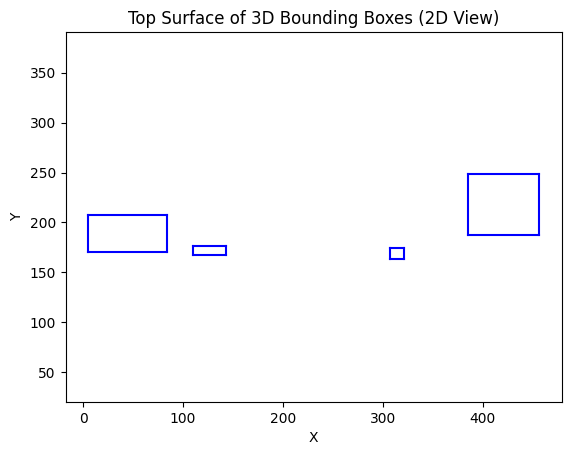

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_surface_2d(bboxes_2d):
    fig, ax = plt.subplots()

    for bbox_2d in bboxes_2d:
        xmin, ymin, xmax, ymax = bbox_2d

        # Estimate 3D box dimensions based on 2D bounding box
        width = xmax - xmin
        height = ymax - ymin
        depth = min(width, height) / 2  # Arbitrary estimation.

        # Estimate 3D box position based on 2D bounding box center
        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2
        z_center = depth / 2  # Arbitrary estimation, need depth map

        # Create vertices for the top surface
        top_vertices = np.array([
            [x_center - width/2, y_center - height/2],
            [x_center + width/2, y_center - height/2],
            [x_center + width/2, y_center + height/2],
            [x_center - width/2, y_center + height/2]
        ])

        # Connect vertices to form the top face
        edges = [[0, 1], [1, 2], [2, 3], [3, 0]]
        for edge in edges:
            ax.plot(
                [top_vertices[edge[0], 0], top_vertices[edge[1], 0]],
                [top_vertices[edge[0], 1], top_vertices[edge[1], 1]],
                'b'
            )

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.title('Top Surface of 3D Bounding Boxes (2D View)')
    plt.axis('equal')  # Ensures that scale is the same on both axes
    plt.show()

# Example usage
bboxes_2d = bboxes

plot_top_surface_2d(bboxes_2d)


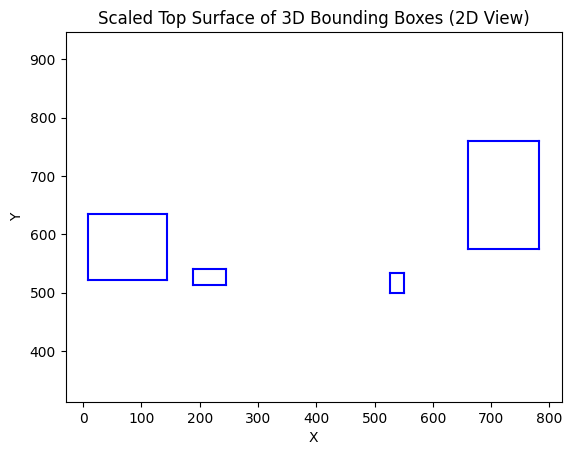

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_scaled_top_surface(bboxes_2d, original_size, target_size):
    fig, ax = plt.subplots()

    orig_width, orig_height = original_size
    target_width, target_height = target_size

    # Scaling factors for x and y dimensions
    x_scale = target_width / orig_width
    y_scale = target_height / orig_height

    for bbox_2d in bboxes_2d:
        xmin, ymin, xmax, ymax = bbox_2d

        # Scale the bounding box coordinates
        xmin_scaled = xmin * x_scale
        xmax_scaled = xmax * x_scale
        ymin_scaled = ymin * y_scale
        ymax_scaled = ymax * y_scale

        # Calculate width, height based on scaled coordinates
        width = xmax_scaled - xmin_scaled
        height = ymax_scaled - ymin_scaled
        depth = min(width, height) / 2  # Arbitrary estimation for demonstration

        # Calculate center based on scaled coordinates
        x_center = (xmin_scaled + xmax_scaled) / 2
        y_center = (ymin_scaled + ymax_scaled) / 2

        # Create vertices for the top surface
        top_vertices = np.array([
            [x_center - width / 2, y_center - height / 2],
            [x_center + width / 2, y_center - height / 2],
            [x_center + width / 2, y_center + height / 2],
            [x_center - width / 2, y_center + height / 2]
        ])

        # Connect vertices to form the top face
        edges = [[0, 1], [1, 2], [2, 3], [3, 0]]
        for edge in edges:
            ax.plot(
                [top_vertices[edge[0], 0], top_vertices[edge[1], 0]],
                [top_vertices[edge[0], 1], top_vertices[edge[1], 1]],
                'b'
            )

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.title('Scaled Top Surface of 3D Bounding Boxes (2D View)')
    plt.axis('equal')  # Ensures that scale is the same on both axes
    plt.show()

# Original and target image sizes
original_size = (672, 376)
target_size = (1152, 1152)

# Example bounding boxes
bboxes_2d = bboxes

plot_scaled_top_surface(bboxes_2d, original_size, target_size)


In [ ]:
#puts boxes onto image
def get_scaled_bboxes(bboxes_2d, original_size, target_size):
    orig_width, orig_height = original_size
    target_width, target_height = target_size

    # Scaling factors for x and y dimensions
    x_scale = target_width / orig_width
    y_scale = target_height / orig_height

    scaled_bboxes = []

    for bbox_2d in bboxes_2d:
        xmin, ymin, xmax, ymax = bbox_2d

        # Scale the bounding box coordinates
        xmin_scaled = xmin * x_scale
        xmax_scaled = xmax * x_scale
        ymin_scaled = ymin * y_scale
        ymax_scaled = ymax * y_scale

        # Add the scaled bounding box to the list
        scaled_bboxes.append([xmin_scaled, ymin_scaled, xmax_scaled, ymax_scaled])

    return scaled_bboxes

# Example usage
original_size = (672, 376)
target_size = (1152, 1152)

bboxes_2d = bboxes

# Get the scaled bounding boxes
scaled_bboxes = get_scaled_bboxes(bboxes_2d, original_size, target_size)

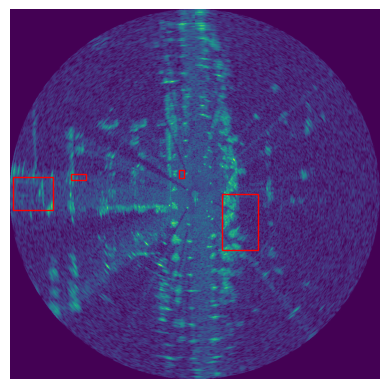

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Load and display the image
image_path = '/content/000024.png'
image = plt.imread(image_path)
fig, ax = plt.subplots()
ax.imshow(image)

# Assuming bboxes_2d are already scaled to fit the image resolution
bboxes_2d = scaled_bboxes

# Create and add rectangles for each bounding box
for bbox_2d in bboxes_2d:
    xmin, ymin, xmax, ymax = bbox_2d
    width = xmax - xmin
    height = ymax - ymin
    rect = Rectangle((xmin, ymin), width-10, height-10, linewidth=1, edgecolor='r', facecolor='none') #translated to acount for front only view
    ax.add_patch(rect)

plt.axis('off')  # Optionally remove the axes
plt.show()


Below is the comparison on the radar BEV. Without sensor fusion, we cannot accomplish knowing the rotation and orientation of objects, and distances accurately.

\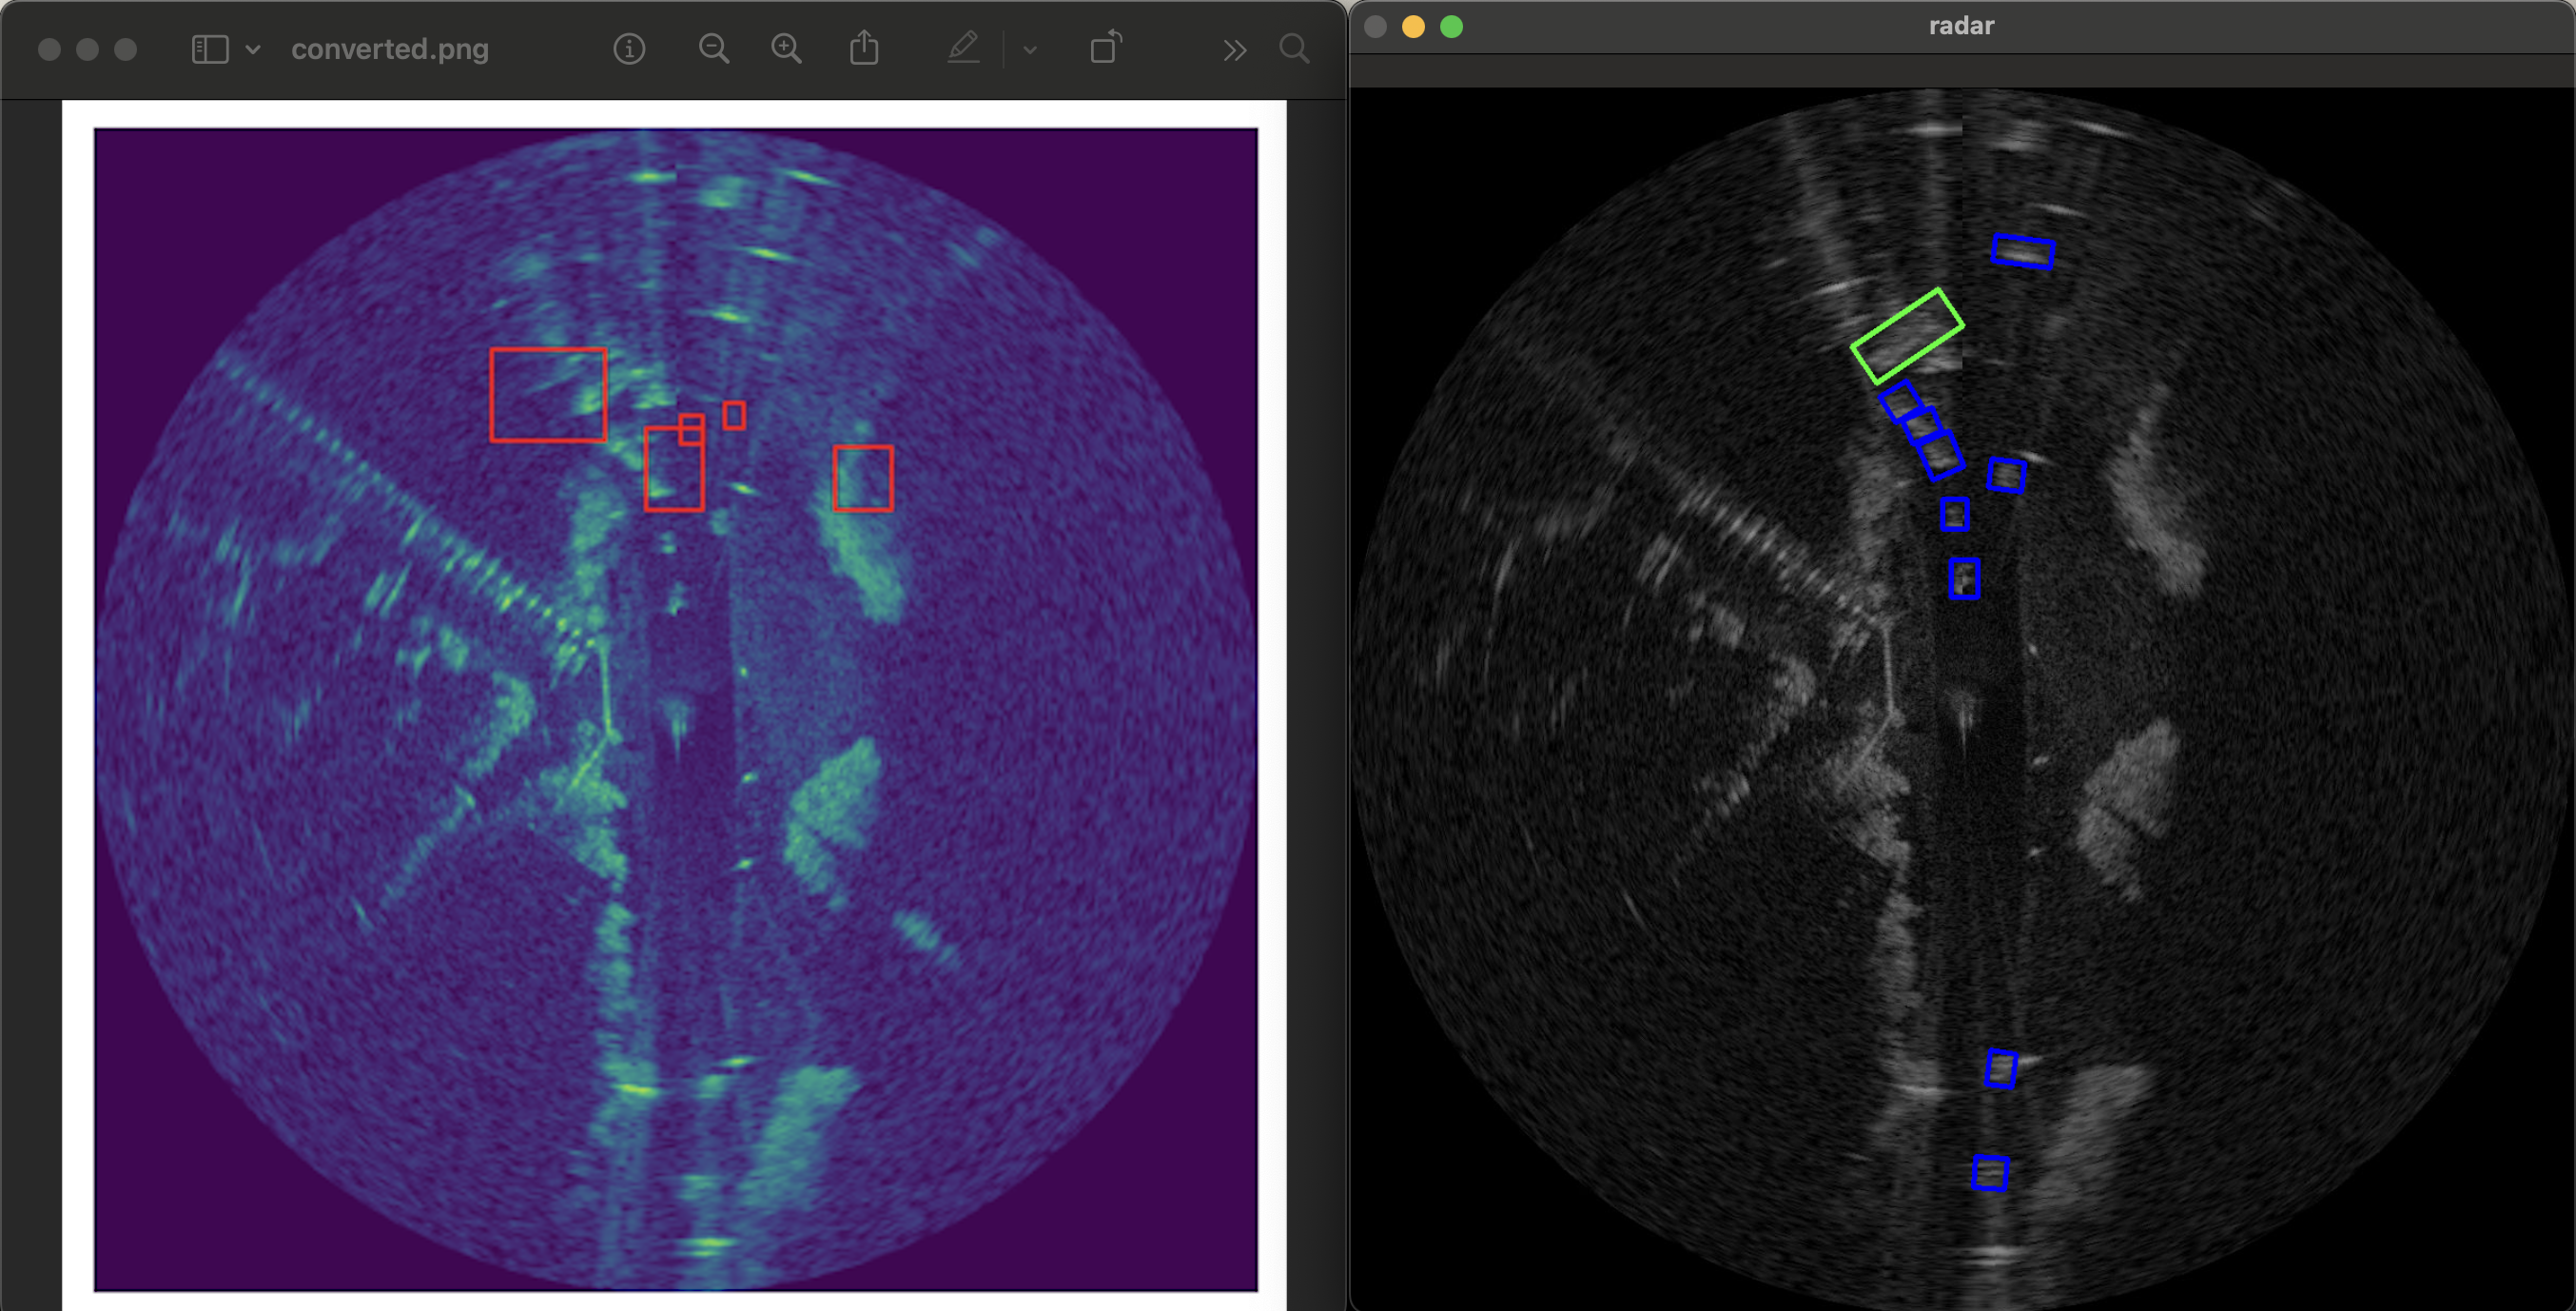